数据分析和清洗

In [1]:
import numpy as np
import torch
import pandas as pd
from transformers import AutoTokenizer
import pickle
import pandas as pd
from entity_dataset2 import EntityDataset

tok = AutoTokenizer.from_pretrained("/home/cs/yangyuchen/yushengliao/Medical_LLM/FastChat/checkpoints/medical_llama_13b_chatv1.3/checkpoint-4974/")
tok.padding_side = 'right'
tok.pad_token = tok.eos_token
tok.pad_token_id = tok.eos_token_id
tok.add_tokens(["[DASH]"])
dst = EntityDataset(data_path='data/kg_HealthCareMagic-20k_train.json', kg_path='data/bios_kg_with_def.csv', tokenizer=tok)

Loaded dataset with 20000 elements


In [2]:
from tqdm.auto import tqdm

input_ids_list, attention_mask_list, labels_list, hard_position_type_ids_list, position_ids_list = dst.make_inputs()

  0%|          | 0/20000 [00:00<?, ?it/s]

<Axes: >

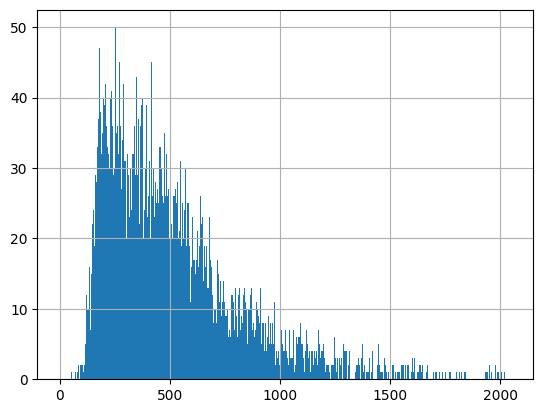

In [19]:
import pandas as pd

pd.Series(input_ids_list).apply(len).hist(range=(0,4096),bins=2048)

In [ ]:
from pprint import pprint
target_index = 1
print('target_index: ', target_index)
input_ids, attention_mask, labels, hard_position_type_ids, position_ids = dst[target_index]
prompt = tok.decode(input_ids)
pprint(prompt)
print('seq_len: ', input_ids.shape[-1])

tokens = tok.batch_decode(input_ids)
tokens = [t.replace('\n', '\\n') for t in tokens]
tokens = [f"{t}-{int(hard_position_type_ids[i])}-{position_ids[i]}-{int(int(labels[i])!=-100)}" for i,t in enumerate(tokens)]
attention_mask = attention_mask.numpy().tolist()
attention_mask = [[int(i) for i in row] for row in attention_mask]

matrix = attention_mask
row_index = tokens
col_index = tokens

max_row_length = max(len(row) for row in row_index)
max_col_length = max(len(col) for col in col_index)

# 打开文件
with open(f'dst_{target_index}.txt', 'w') as f:
    f.write(prompt+ '\n\n')
    f.write('attention_mask:\n0:non-entity tokens，1:entity tokens, 2:triplet tokens, 3:triplet target tokens\n\n')
    # 写入列索引
    f.write(" " * max_row_length + "  " + "  ".join(col.ljust(max_col_length) for col in col_index) + '\n')
    # 写入行索引和每行的值
    for j, row in enumerate(matrix):
        f.write(row_index[j].ljust(max_row_length) + "  " + "  ".join(str(val).ljust(max_col_length) for val in row) + '\n')
        
# 创建DataFrame对象
df = pd.DataFrame(matrix, index=row_index, columns=col_index)

# 将DataFrame写入CSV文件
df.to_csv(f'dst_{target_index}.csv')

In [6]:
tok("If same thing happen again let me know. </s>")

{'input_ids': [1, 960, 1021, 2655, 3799, 1449, 1235, 592, 1073, 29889, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

# 读取BIOS

In [1]:
relations = open("data/bios_v2.2_release/CoreData/Relations.txt").readlines()
uni_relations = open("data/bios_v2.2_release/CoreData/UniRelations.txt").readlines()
definitions = open("data/bios_v2.2_release/CoreData/Definitions.txt").readlines()
concept_terms = open("data/bios_v2.2_release/CoreData/ConceptTerms.txt").readlines()
semantic_types = open("data/bios_v2.2_release/CoreData/SemanticTypes.txt").readlines()

In [5]:
from collections import defaultdict
from tqdm import tqdm

concept2term = defaultdict(list)

for line in tqdm(concept_terms):
    ls = line.strip().split('|')
    concept2term[ls[0]].append({'TID': ls[1], 'STR': ls[2]})

concept2relations = defaultdict(list)

for line in tqdm(uni_relations):
    rid, head, tail, relid, rel = line.strip().split("|")
    concept2relations[head].append({'TAIL': tail, 'REL':rel})

def find_neighbor_by_cid(cid):
    print(f"CID: {cid} ")
    for i in concept2term[cid]:
        print(f"TID: {i['TID']} STR: {i['STR']}")
    print(f"Relations Num: {len(concept2relations[cid])}")
    print(f"Relations Num: {len(concept2relations[cid])}")

100%|██████████| 34918237/34918237 [01:13<00:00, 477621.60it/s] 


In [ ]:
cid = "CN32837053"
find_neighbor_by_cid(cid)

# 图分析

In [2]:
from tqdm import tqdm
import igraph as ig
import matplotlib.pyplot as plt

nodes = {}

for line in tqdm(uni_relations):
    rid, head, tail, relid, rel = line.strip().split("|")
    if not nodes.get(head):
        nodes[head] = len(nodes)
    if not nodes.get(tail):
        nodes[tail] = len(nodes)

idx2node=[x[0] for x in sorted(nodes.items(), key=lambda x: x[1])]

edges = [(nodes[rl.strip().split("|")[1]],nodes[rl.strip().split("|")[2]]) for rl in uni_relations]

g = ig.Graph(n=len(nodes), edges=edges, directed=True)

for i in range(len(g.vs)):
    g.vs[i]["cid"] = idx2node[i]
    g.vs[i]["name"] = concept2term[idx2node[i]][0]['STR']

100%|██████████| 34918237/34918237 [00:30<00:00, 1145432.54it/s]


In [9]:
g.vs[100]

igraph.Vertex(<igraph.Graph object at 0x146e259d7640>, 100, {'name': 'fusion gene protein', 'cid': 'CN10802400'})

In [10]:
components = g.connected_components(mode='weak')
print('len(components): ', len(components))

subg = g.subgraph(max(components, key=len))
print('largest components size: ', len(max(components, key=len)))

bridges = subg.bridges()
print('len(bridges): ', len(bridges))

len(components):  25377
largest components size:  13643890
len(bridges):  4542692


In [55]:
rank = subg.pagerank(directed=True, damping=0.85, )
sorted_indices = sorted(range(len(rank)), key=lambda i: rank[i], reverse=True)

In [68]:
for i in range(100):
    print('Rank: %d, Score: %.4f, Node: %s' % (i+1, rank[sorted_indices[i]], subg.vs[sorted_indices[i]]['name']))

Rank: 1, Score: 0.2096, Node: organic compound
Rank: 2, Score: 0.0380, Node: amino acid, peptide, or protein
Rank: 3, Score: 0.0325, Node: medication dose
Rank: 4, Score: 0.0289, Node: inorganic chemical
Rank: 5, Score: 0.0246, Node: bacterial organism
Rank: 6, Score: 0.0234, Node: class mammalia
Rank: 7, Score: 0.0156, Node: biologic active agents
Rank: 8, Score: 0.0124, Node: viral agent
Rank: 9, Score: 0.0087, Node: immunotherapic agent
Rank: 10, Score: 0.0085, Node: biomedical or dental material
Rank: 11, Score: 0.0064, Node: nucleic acid, nucleoside, or nucleotide
Rank: 12, Score: 0.0060, Node: enzyme
Rank: 13, Score: 0.0058, Node: hazardous or poisonous substance
Rank: 14, Score: 0.0054, Node: indicator, reagent, or diagnostic aid
Rank: 15, Score: 0.0033, Node: anti microbial agents
Rank: 16, Score: 0.0030, Node: drugtherapy
Rank: 17, Score: 0.0029, Node: vitamin
Rank: 18, Score: 0.0026, Node: ror receptor
Rank: 19, Score: 0.0024, Node: eosinophil gastroenteritis
Rank: 20, Score:

In [56]:
sorted_indices[:10]

[140, 9013429, 118, 4921, 1131, 1966, 7341, 10167, 73, 9013430]

<Axes: >

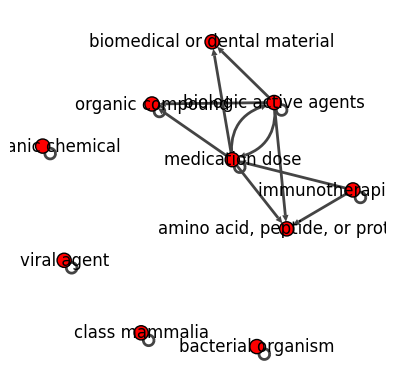

In [72]:
fig, ax = plt.subplots()
vipg = subg.subgraph(sorted_indices[:10])

visual_style = {}
visual_style["vertex_label"] = vipg.vs["name"]
visual_style["layout"] = vipg.layout("kk")
visual_style["target"] = ax
ig.plot(
    vipg,
    **visual_style,
)